In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models, utils
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from PIL import Image, ImageDraw, ImageFilter
from tqdm import tqdm
import torch.backends.cudnn as cudnn

import sys
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

#Configuration


In [ ]:
class Args:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.dataset = 'cifar10'
        self.model = 'mobilenet_v2'
        self.batch_size = 128
        self.epochs_adv = 100
        self.learning_rate = 0.1
        self.image_size = 32
        self.save_dir = 'robust_classifier_project_output'
        self.checkpoint = f'{self.model}_robust_cifar10.pth'
        # Modes: 'train', 'demo_all', 'generate', 'inpaint', etc.
        self.mode = 'train'

args = Args()
os.makedirs(args.save_dir, exist_ok=True)
device = args.device


# Data and Model Utilities


In [ ]:
def get_cifar10_loader(batch_size, image_size=32):
    """Load CIFAR-10 data"""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    return trainloader, testloader, len(classes), classes

def build_model(model_name, num_classes):
    """Build model and adapt classifier head"""
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError("Model not supported.")
    return model

def save_checkpoint(model, path):
    """Save model checkpoint"""
    print(f"Saving model to {path}")
    torch.save(model.state_dict(), path)

def load_checkpoint(model, path, device):
    """Load model checkpoint"""
    if not os.path.exists(path):
        print(f"Checkpoint not found at {path}. Model must be trained.")
        return False
    print(f"Loading model from {path}")
    model.load_state_dict(torch.load(path, map_location=device))
    return True


#Adversarial Training (L2 PGD)


In [ ]:
def l2_pgd_attack(model, X, y, epsilon, num_steps, step_size):
    """L2 PGD attack for robust training"""
    X_pgd = X.clone().detach()
    X_pgd.requires_grad = True

    mu = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1).to(device)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1).to(device)

    for _ in range(num_steps):
        opt = optim.SGD([X_pgd], lr=1e-3)
        opt.zero_grad()
        with torch.enable_grad():
            loss = F.cross_entropy(model(X_pgd), y)
        loss.backward()

        grad = X_pgd.grad.data
        norm_grad = torch.norm(grad.reshape(grad.shape[0], -1), p=2, dim=1).view(-1, 1, 1, 1)
        X_pgd.data += step_size * grad / (norm_grad + 1e-12)

        delta = X_pgd.data - X.data
        delta_norm = torch.norm(delta.view(delta.shape[0], -1), p=2, dim=1)
        factor = torch.min(torch.ones_like(delta_norm), epsilon / delta_norm)
        delta = delta * factor.view(-1, 1, 1, 1)
        X_pgd.data = X.data + delta

        X_pgd.data = torch.min(torch.max(X_pgd.data, (0 - mu) / std), (1 - mu) / std)

    return X_pgd.detach()


def train_adversarial(args, train_loader, test_loader, num_classes, device):
    """Train robust model using PGD-Adversarial Training"""
    model = build_model(args.model, num_classes).to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.learning_rate, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs_adv)

    epsilon = 128 / 255 / 0.2
    num_steps = 7
    step_size = 2 / 255 / 0.2

    print(f"Starting Robust Training: {args.model}")

    for epoch in range(args.epochs_adv):
        model.train()
        tqdm_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{args.epochs_adv}")
        for batch_idx, (data, target) in enumerate(tqdm_loader):
            data, target = data.to(device), target.to(device)
            X_adv = l2_pgd_attack(model, data, target, epsilon, num_steps, step_size)

            optimizer.zero_grad()
            output = model(X_adv)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

            tqdm_loader.set_postfix(loss=loss.item())

        scheduler.step()

    checkpoint_path = os.path.join(args.save_dir, args.checkpoint)
    save_checkpoint(model, checkpoint_path)
    return model



#Image Synthesis Core


In [ ]:

inv_normalize = transforms.Normalize(
    mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010],
    std=[1/0.2023, 1/0.1994, 1/0.2010]
)

def apply_pgd_optimization(model, x, loss_fn, steps=1000, lr=0.1):
    """PGD optimization for image synthesis (Gradient Ascent)"""
    x.requires_grad = True
    optimizer = optim.Adam([x], lr=lr)

    mu = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1).to(x.device)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1).to(x.device)

    for step in tqdm(range(steps), desc="PGD Optimization"):
        optimizer.zero_grad()

        loss = loss_fn(model, x)

        (-loss).backward() # Gradient ascent

        optimizer.step()

        with torch.no_grad():
            x.data = torch.min(torch.max(x.data, (0 - mu) / std), (1 - mu) / std)

    return x.detach()



#Sample Input Generators

In [ ]:


def create_sample_mask(size):
    """Generate a sample inpainting mask"""
    mask = Image.new('L', (size, size), 0)
    draw = ImageDraw.Draw(mask)
    draw.rectangle([size//4, size//4, size*3//4, size*3//4], fill=255)
    mask_tensor = transforms.ToTensor()(mask)
    return (mask_tensor < 0.5).float()

def downsample_image(x, scale_factor=0.5):
    """Simulate low-resolution image"""
    low_res = F.interpolate(x, scale_factor=scale_factor, mode='bilinear', align_corners=False)
    return F.interpolate(low_res, size=x.shape[-2:], mode='bilinear', align_corners=False)

def create_sample_sketch(size):
    """Generate a sample sketch (black circle)"""
    img = Image.new('RGB', (size, size), 'white')
    draw = ImageDraw.Draw(img)
    draw.ellipse((size//4, size//4, size*3//4, size*3//4), fill='black')

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    return transform(img)




#Synthesis Tasks


In [ ]:
def generate_images(model, target_class_idx, num_samples, lr, device, save_dir, classes):
    """Task: Image Generation"""
    print(f"Generating {num_samples} image(s) for class: {classes[target_class_idx]}")
    model.eval()
    initial_input = torch.randn(num_samples, 3, args.image_size, args.image_size).to(device)

    def generation_loss(model, x):
        output = model(x)
        return output[:, target_class_idx].mean()

    generated_images = apply_pgd_optimization(model, initial_input, generation_loss, steps=2000, lr=lr)

    grid = utils.make_grid(generated_images.cpu(), nrow=int(np.sqrt(num_samples)))
    utils.save_image(grid, os.path.join(save_dir, f'generated_class_{target_class_idx}.png'))
    return grid

def inpaint_image(model, original_image, mask, target_class_idx, lr, device, save_dir, classes):
    """Task: Image Inpainting"""
    print(f"Inpainting image for class: {classes[target_class_idx]}")
    model.eval()
    original_image = original_image.to(device).unsqueeze(0)
    mask = mask.to(device).unsqueeze(0)

    corrupted_image = original_image.clone().detach() * (1 - mask)
    x = corrupted_image.clone().detach().to(device)

    def inpainting_loss(model, x):
        """Loss: Maximize class score - Penalize changes to uncorrupted regions"""
        output = model(x)
        class_loss = output[:, target_class_idx].mean()
        consistency_loss = torch.norm((x - original_image) * (1 - mask), p=2)
        return class_loss - 20.0 * consistency_loss

    inpainted_image = apply_pgd_optimization(model, x, inpainting_loss, steps=1000, lr=lr)

    output_grid = utils.make_grid([original_image.cpu().squeeze(0), corrupted_image.cpu().squeeze(0), inpainted_image.cpu().squeeze(0)], nrow=3)
    utils.save_image(output_grid, os.path.join(save_dir, f'inpainting_class_{target_class_idx}.png'))
    return output_grid

def super_resolution(model, low_res_image, target_class_idx, lr, device, save_dir, classes):
    """Task: Super-Resolution"""
    print(f"Super-Resolution for class: {classes[target_class_idx]}")
    model.eval()

    initial_input = low_res_image.to(device).unsqueeze(0)
    x = initial_input.clone().detach().to(device)

    def super_resolution_loss(model, x):
        """Loss: Maximize class score - Penalize deviation from low-res image"""
        output = model(x)
        class_loss = output[:, target_class_idx].mean()

        downsampled_x = downsample_image(x, scale_factor=0.5)
        downsampled_initial = downsample_image(initial_input, scale_factor=0.5)

        consistency_loss = torch.norm(downsampled_x - downsampled_initial, p=2)

        return class_loss - 5.0 * consistency_loss

    high_res_image = apply_pgd_optimization(model, x, super_resolution_loss, steps=1500, lr=lr)

    output_grid = utils.make_grid([low_res_image.cpu(), high_res_image.cpu().squeeze(0)], nrow=2)
    utils.save_image(output_grid, os.path.join(save_dir, f'super_res_class_{target_class_idx}.png'))
    return output_grid

def sketch_to_image(model, sketch_map, target_class_idx, lr, device, save_dir, classes):
    """Task: Sketch-to-Image Translation"""
    print(f"Sketch-to-Image for class: {classes[target_class_idx]}")
    model.eval()

    initial_input = torch.zeros(1, 3, args.image_size, args.image_size).to(device) + 0.5
    x = initial_input.clone().detach().to(device)
    sketch_map = sketch_map.to(device).unsqueeze(0)

    def sketch_to_image_loss(model, x):
        """Loss: Maximize class score - Penalize changes to non-sketch (white) areas"""
        output = model(x)
        class_loss = output[:, target_class_idx].mean()

        # Penalize deviation
        adherence_loss = torch.norm((x - initial_input) * (1.0 - sketch_map.mean(dim=1, keepdim=True)), p=2)

        return class_loss - 0.5 * adherence_loss

    generated_image = apply_pgd_optimization(model, x, sketch_to_image_loss, steps=2500, lr=lr)

    output_grid = utils.make_grid([inv_normalize(sketch_map.cpu().squeeze(0)).clamp(0,1), generated_image.cpu().squeeze(0)], nrow=2)
    utils.save_image(output_grid, os.path.join(save_dir, f'sketch_to_image_class_{target_class_idx}.png'))
    return output_grid

def image_to_image_translation(model, source_image, source_class, target_class, lr, device, save_dir, classes):
    """Task: Image-to-Image Translation"""
    print(f"Image Translation: {classes[source_class]} to {classes[target_class]}")
    model.eval()

    x = source_image.clone().detach().to(device).unsqueeze(0)

    def translation_loss(model, x):
        """Loss: Maximize target class score - Penalize large deviation from source image"""
        output = model(x)
        class_loss = output[:, target_class].mean()

        consistency_loss = torch.norm((x - source_image.to(device).unsqueeze(0)), p=2)

        return class_loss - 0.05 * consistency_loss

    translated_image = apply_pgd_optimization(model, x, translation_loss, steps=2000, lr=lr)

    output_grid = utils.make_grid([source_image.cpu(), translated_image.cpu().squeeze(0)], nrow=2)
    utils.save_image(output_grid, os.path.join(save_dir, f'translate_{source_class}_to_{target_class}.png'))
    return output_grid



#Main Execution

In [4]:
def main():
    train_loader, test_loader, num_classes, classes = get_cifar10_loader(args.batch_size, args.image_size)

    if args.mode == 'train':
        train_adversarial(args, train_loader, test_loader, num_classes, device)

    elif args.mode.startswith('demo') or args.mode in ['generate', 'inpaint', 'super_res', 'sketch_to_image', 'translate']:
        model = build_model(args.model, num_classes).to(device)
        checkpoint_path = os.path.join(args.save_dir, args.checkpoint)

        if not load_checkpoint(model, checkpoint_path, device):
            print("Please train the model first using 'train' mode.")
            return

        # Sample inputs for demonstration
        sample_image_plane, sample_label_plane = test_loader.dataset[0]
        sample_image_horse, sample_label_horse = test_loader.dataset[7]
        low_res_plane = downsample_image(sample_image_plane.unsqueeze(0)).squeeze(0)
        sample_sketch = create_sample_sketch(args.image_size)

        if args.mode == 'generate' or args.mode == 'demo_all':
            generate_images(model, target_class_idx=1, num_samples=9, lr=0.01, device=device, save_dir=args.save_dir, classes=classes)

        if args.mode == 'inpaint' or args.mode == 'demo_all':
            mask = create_sample_mask(args.image_size)
            inpaint_image(model, sample_image_plane, mask, target_class_idx=sample_label_plane.item(), lr=0.01, device=device, save_dir=args.save_dir, classes=classes)

        if args.mode == 'super_res' or args.mode == 'demo_all':
            super_resolution(model, low_res_plane, target_class_idx=sample_label_plane.item(), lr=0.01, device=device, save_dir=args.save_dir, classes=classes)

        if args.mode == 'sketch_to_image' or args.mode == 'demo_all':
            sketch_to_image(model, sample_sketch, target_class_idx=3, lr=0.01, device=device, save_dir=args.save_dir, classes=classes)

        if args.mode == 'translate' or args.mode == 'demo_all':
            image_to_image_translation(model, sample_image_horse, source_class=sample_label_horse.item(), target_class=9, lr=0.01, device=device, save_dir=args.save_dir, classes=classes)


if __name__ == '__main__':
    main()

Starting Robust Training: mobilenet_v2


Epoch 100/100: 100%|██████████| 391/391 [01:17<00:00,  5.06it/s, loss=0.545]


Saving model to robust_classifier_project_output/mobilenet_v2_robust_cifar10.pth



#Configuration

In [ ]:
class Args:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.dataset = 'cifar10'
        self.model = 'mobilenet_v2'
        self.batch_size = 128
        self.epochs_adv = 100
        self.learning_rate = 0.1
        self.image_size = 32
        self.save_dir = 'robust_classifier_project_output'
        self.checkpoint = f'{self.model}_robust_cifar10.pth'
        # Mode: 'train', 'demo_all', 'generate', 'inpaint', etc.
        self.mode = 'demo_all'

args = Args()
os.makedirs(args.save_dir, exist_ok=True)
device = args.device


# Data and Model Utilities


In [ ]:
def get_cifar10_loader(batch_size, image_size=32):
    """Load CIFAR-10 data"""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    return trainloader, testloader, len(classes), classes

def build_model(model_name, num_classes):
    """Build MobileNetV2 and adapt classifier head"""
    if model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError("Model not supported.")
    return model

def save_checkpoint(model, path):
    """Save model checkpoint"""
    print(f"Saving model to {path}")
    torch.save(model.state_dict(), path)

def load_checkpoint(model, path, device):
    """Load model checkpoint"""
    if not os.path.exists(path):
        print(f"Checkpoint not found at {path}.")
        return False
    print(f"Loading model from {path}")
    model.load_state_dict(torch.load(path, map_location=device))
    return True


#Adversarial Training (L2 PGD)

In [ ]:
def l2_pgd_attack(model, X, y, epsilon, num_steps, step_size):
    """L2 PGD attack: generate adversarial examples"""
    X_pgd = X.clone().detach()
    X_pgd.requires_grad = True

    mu = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1).to(device)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1).to(device)

    for _ in range(num_steps):
        opt = optim.SGD([X_pgd], lr=1e-3)
        opt.zero_grad()
        with torch.enable_grad():
            loss = F.cross_entropy(model(X_pgd), y)
        loss.backward()

        grad = X_pgd.grad.data
        norm_grad = torch.norm(grad.reshape(grad.shape[0], -1), p=2, dim=1).view(-1, 1, 1, 1)
        X_pgd.data += step_size * grad / (norm_grad + 1e-12)

        # L2 Projection
        delta = X_pgd.data - X.data
        delta_norm = torch.norm(delta.view(delta.shape[0], -1), p=2, dim=1)
        factor = torch.min(torch.ones_like(delta_norm), epsilon / delta_norm)
        delta = delta * factor.view(-1, 1, 1, 1)
        X_pgd.data = X.data + delta

        # Clipping to image bounds
        X_pgd.data = torch.min(torch.max(X_pgd.data, (0 - mu) / std), (1 - mu) / std)

    return X_pgd.detach()


def train_adversarial(args, train_loader, test_loader, num_classes, device):
    """Train adversarially robust model"""
    model = build_model(args.model, num_classes).to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.learning_rate, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs_adv)

    epsilon = 128 / 255 / 0.2
    num_steps = 7
    step_size = 2 / 255 / 0.2

    print(f"Starting Robust Training ({args.model}) with L2 PGD...")

    for epoch in range(args.epochs_adv):
        model.train()
        tqdm_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{args.epochs_adv}")
        for data, target in tqdm_loader:
            data, target = data.to(device), target.to(device)
            X_adv = l2_pgd_attack(model, data, target, epsilon, num_steps, step_size)

            optimizer.zero_grad()
            output = model(X_adv)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

            tqdm_loader.set_postfix(loss=loss.item())

        scheduler.step()

    checkpoint_path = os.path.join(args.save_dir, args.checkpoint)
    save_checkpoint(model, checkpoint_path)
    return model



# Image Synthesis Core


In [ ]:

# Inverse normalization for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010],
    std=[1/0.2023, 1/0.1994, 1/0.2010]
)

def apply_pgd_optimization(model, x, loss_fn, steps=1000, lr=0.1):
    """PGD-based optimization for image synthesis (Gradient Ascent)"""
    x.requires_grad = True
    optimizer = optim.Adam([x], lr=lr)

    mu = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1).to(x.device)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1).to(x.device)

    for _ in tqdm(range(steps), desc="PGD Optimization"):
        optimizer.zero_grad()
        loss = loss_fn(model, x)
        (-loss).backward() # Gradient ascent
        optimizer.step()

        with torch.no_grad():
            x.data = torch.min(torch.max(x.data, (0 - mu) / std), (1 - mu) / std)

    return x.detach()



# Sample Input Generators

In [ ]:


def create_sample_mask(size):
    """Generate a sample inpainting mask (center square)"""
    mask = Image.new('L', (size, size), 0)
    draw = ImageDraw.Draw(mask)
    draw.rectangle([size//4, size//4, size*3//4, size*3//4], fill=255)
    mask_tensor = transforms.ToTensor()(mask)
    return (mask_tensor < 0.5).float()

def downsample_image(x, scale_factor=0.5):
    """Simulate low-resolution image by down/up-sampling"""
    low_res = F.interpolate(x, scale_factor=scale_factor, mode='bilinear', align_corners=False)
    return F.interpolate(low_res, size=x.shape[-2:], mode='bilinear', align_corners=False)

def create_sample_sketch(size):
    """Generate a sample sketch (black circle on white)"""
    img = Image.new('RGB', (size, size), 'white')
    draw = ImageDraw.Draw(img)
    draw.ellipse((size//4, size//4, size*3//4, size*3//4), fill='black')
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    return transform(img)


#Synthesis Tasks Implementations


In [ ]:

def generate_images(model, target_class_idx, num_samples, lr, device, save_dir, classes):
    """  Image Generation"""
    print(f"Generating {num_samples} image(s) for class: {classes[target_class_idx]}")
    model.eval()
    initial_input = torch.randn(num_samples, 3, args.image_size, args.image_size).to(device)

    def generation_loss(model, x):
        output = model(x)
        return output[:, target_class_idx].mean()

    generated_images = apply_pgd_optimization(model, initial_input, generation_loss, steps=2000, lr=lr)
    grid = utils.make_grid(generated_images.cpu(), nrow=int(np.sqrt(num_samples)))
    utils.save_image(grid, os.path.join(save_dir, f'generated_class_{target_class_idx}.png'))
    return grid

def inpaint_image(model, original_image, mask, target_class_idx, lr, device, save_dir, classes):
    """  Image Inpainting"""
    print(f"Inpainting image for class: {classes[target_class_idx]}")
    model.eval()
    original_image = original_image.to(device).unsqueeze(0)
    mask = mask.to(device).unsqueeze(0)
    corrupted_image = original_image.clone().detach() * (1 - mask)
    x = corrupted_image.clone().detach().to(device)

    def inpainting_loss(model, x):
        """Loss: Maximize class score - L2 Consistency penalty on uncorrupted regions"""
        output = model(x)
        class_loss = output[:, target_class_idx].mean()
        consistency_loss = torch.norm((x - original_image) * (1 - mask), p=2)
        return class_loss - 20.0 * consistency_loss

    inpainted_image = apply_pgd_optimization(model, x, inpainting_loss, steps=1000, lr=lr)

    output_grid = utils.make_grid([original_image.cpu().squeeze(0), corrupted_image.cpu().squeeze(0), inpainted_image.cpu().squeeze(0)], nrow=3)
    utils.save_image(output_grid, os.path.join(save_dir, f'inpainting_class_{target_class_idx}.png'))
    return output_grid

def super_resolution(model, low_res_image, target_class_idx, lr, device, save_dir, classes):
    """  Super-Resolution"""
    print(f"Super-Resolution for class: {classes[target_class_idx]}")
    model.eval()
    initial_input = low_res_image.to(device).unsqueeze(0)
    x = initial_input.clone().detach().to(device)

    def super_resolution_loss(model, x):
        """Loss: Maximize class score - L2 penalty on low-resolution consistency"""
        output = model(x)
        class_loss = output[:, target_class_idx].mean()
        downsampled_x = downsample_image(x, scale_factor=0.5)
        downsampled_initial = downsample_image(initial_input, scale_factor=0.5)
        consistency_loss = torch.norm(downsampled_x - downsampled_initial, p=2)
        return class_loss - 5.0 * consistency_loss

    high_res_image = apply_pgd_optimization(model, x, super_resolution_loss, steps=1500, lr=lr)

    output_grid = utils.make_grid([low_res_image.cpu(), high_res_image.cpu().squeeze(0)], nrow=2)
    utils.save_image(output_grid, os.path.join(save_dir, f'super_res_class_{target_class_idx}.png'))
    return output_grid

def sketch_to_image(model, sketch_map, target_class_idx, lr, device, save_dir, classes):
    """  Sketch-to-Image Translation"""
    print(f"Sketch-to-Image for class: {classes[target_class_idx]}")
    model.eval()
    initial_input = torch.zeros(1, 3, args.image_size, args.image_size).to(device) + 0.5
    x = initial_input.clone().detach().to(device)
    sketch_map = sketch_map.to(device).unsqueeze(0)

    def sketch_to_image_loss(model, x):
        """Loss: Maximize class score - L2 Adherence penalty on white areas of sketch"""
        output = model(x)
        class_loss = output[:, target_class_idx].mean()
        adherence_loss = torch.norm((x - initial_input) * (1.0 - sketch_map.mean(dim=1, keepdim=True)), p=2)
        return class_loss - 0.5 * adherence_loss

    generated_image = apply_pgd_optimization(model, x, sketch_to_image_loss, steps=2500, lr=lr)

    output_grid = utils.make_grid([inv_normalize(sketch_map.cpu().squeeze(0)).clamp(0,1), generated_image.cpu().squeeze(0)], nrow=2)
    utils.save_image(output_grid, os.path.join(save_dir, f'sketch_to_image_class_{target_class_idx}.png'))
    return output_grid

def image_to_image_translation(model, source_image, source_class, target_class, lr, device, save_dir, classes):
    """ Image-to-Image Translation"""
    print(f"Image Translation: {classes[source_class]} to {classes[target_class]}")
    model.eval()
    x = source_image.clone().detach().to(device).unsqueeze(0)

    def translation_loss(model, x):
        """Loss: Maximize target class score - L2 Consistency penalty for structure preservation"""
        output = model(x)
        class_loss = output[:, target_class].mean()
        consistency_loss = torch.norm((x - source_image.to(device).unsqueeze(0)), p=2)
        return class_loss - 0.05 * consistency_loss

    translated_image = apply_pgd_optimization(model, x, translation_loss, steps=2000, lr=lr)

    output_grid = utils.make_grid([source_image.cpu(), translated_image.cpu().squeeze(0)], nrow=2)
    utils.save_image(output_grid, os.path.join(save_dir, f'translate_{source_class}_to_{target_class}.png'))
    return output_grid


#Main Execution  

In [5]:
def main():
    train_loader, test_loader, num_classes, classes = get_cifar10_loader(args.batch_size, args.image_size)

    model = build_model(args.model, num_classes).to(device)
    checkpoint_path = os.path.join(args.save_dir, args.checkpoint)

    # the trained model
    is_loaded = load_checkpoint(model, checkpoint_path, device)

    if args.mode == 'train' or not is_loaded:
        print("\n--- Running  Robust Model Training ---")
        model = train_adversarial(args, train_loader, test_loader, num_classes, device)
        is_loaded = True

    if args.mode == 'train':
        print("Training finished.")
        return

    if is_loaded:
        print("\n---  Image Synthesis Demos ---")

        # Sample inputs for demonstration
        sample_image_plane, sample_label_plane = test_loader.dataset[0]
        sample_image_horse, sample_label_horse = test_loader.dataset[7]
        low_res_plane = downsample_image(sample_image_plane.unsqueeze(0)).squeeze(0)
        sample_sketch = create_sample_sketch(args.image_size)

        # Execute synthesis tasks

        if args.mode == 'generate' or args.mode == 'demo_all':
            generate_images(model, target_class_idx=1, num_samples=9, lr=0.01, device=device, save_dir=args.save_dir, classes=classes)

        if args.mode == 'inpaint' or args.mode == 'demo_all':
            mask = create_sample_mask(args.image_size)
            inpaint_image(model, sample_image_plane, mask, target_class_idx=sample_label_plane, lr=0.01, device=device, save_dir=args.save_dir, classes=classes)

        if args.mode == 'super_res' or args.mode == 'demo_all':
            super_resolution(model, low_res_plane, target_class_idx=sample_label_plane, lr=0.01, device=device, save_dir=args.save_dir, classes=classes)

        if args.mode == 'sketch_to_image' or args.mode == 'demo_all':
            sketch_to_image(model, sample_sketch, target_class_idx=3, lr=0.01, device=device, save_dir=args.save_dir, classes=classes)

        if args.mode == 'translate' or args.mode == 'demo_all':
            image_to_image_translation(model, sample_image_horse, source_class=sample_label_horse, target_class=9, lr=0.01, device=device, save_dir=args.save_dir, classes=classes)


if __name__ == '__main__':
    main()

Loading model from robust_classifier_project_output/mobilenet_v2_robust_cifar10.pth

--- Running Stage 2: Image Synthesis Demos ---
Generating 9 image(s) for class: car


PGD Optimization: 100%|██████████| 2000/2000 [00:39<00:00, 50.73it/s]


Inpainting image for class: cat


PGD Optimization: 100%|██████████| 1000/1000 [00:16<00:00, 61.19it/s]


Super-Resolution for class: cat


PGD Optimization: 100%|██████████| 1500/1500 [00:24<00:00, 60.46it/s]


Sketch-to-Image for class: cat


PGD Optimization: 100%|██████████| 2500/2500 [00:42<00:00, 59.02it/s]


Image Translation: frog to truck


PGD Optimization: 100%|██████████| 2000/2000 [00:32<00:00, 60.91it/s]

All image synthesis tasks executed.


## Image Generation - Car

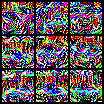

## Image Inpainting - Cat

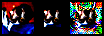

## Super-Resolution - Cat

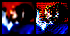

## Sketch-to-Image - Cat

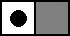

## Image-to-Image Translation - Frog to Truck

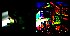

In [6]:

save_dir = 'robust_classifier_project_output'
files_to_display = [
    ('Image Generation - Car', 'generated_class_1.png'),
    ('Image Inpainting - Cat', 'inpainting_class_3.png'),
    ('Super-Resolution - Cat', 'super_res_class_3.png'),
    ('Sketch-to-Image - Cat', 'sketch_to_image_class_3.png'),
    ('Image-to-Image Translation - Frog to Truck', 'translate_6_to_9.png')
]

for title, file_name in files_to_display:
    file_path = os.path.join(save_dir, file_name)
    if os.path.exists(file_path):
        display(Markdown(f"## {title}"))
        try:
            img = Image.open(file_path)
            display(img)
        except Exception as e:
            print(f"Error displaying {file_name}: {e}")
    else:
        print(f"File not found: {file_name}")

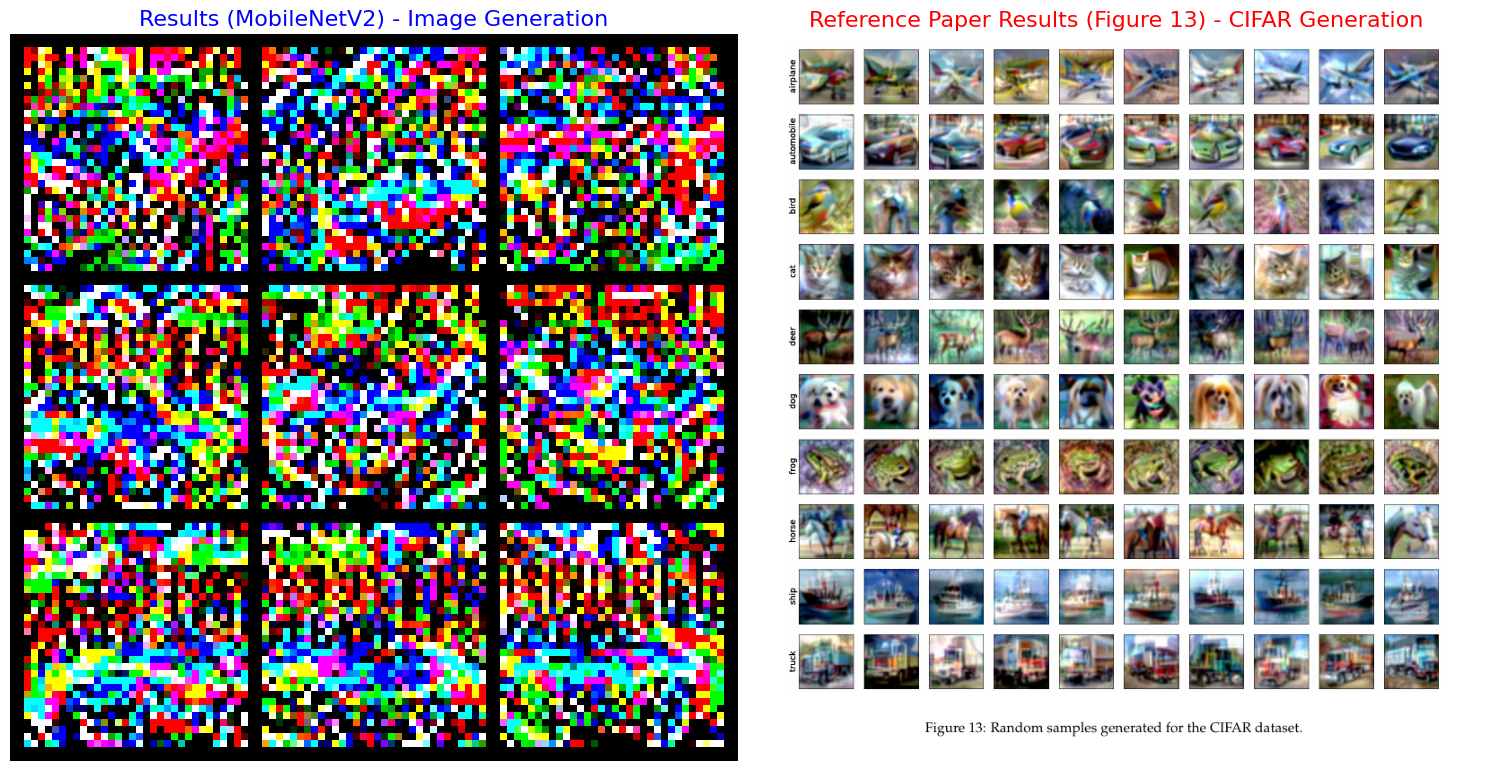

In [7]:

# Define paths
SAVE_DIR = 'robust_classifier_project_output'
YOUR_IMAGE_PATH = os.path.join(SAVE_DIR, 'generated_class_1.png')
REFERENCE_IMAGE_PATH = '/content/robust_classifier_project_output/reference_cifar_generation.png'

# Check for reference image upload
if not os.path.exists(REFERENCE_IMAGE_PATH):

    #  Display only the user's generated
    if os.path.exists(YOUR_IMAGE_PATH):
        try:
            img_yours = Image.open(YOUR_IMAGE_PATH)
            plt.figure(figsize=(6, 6))
            plt.title(f"Your Output Only (MobileNetV2 - Car)")
            plt.imshow(img_yours)
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Error displaying your image: {e}")

    sys.exit()

# Load images
try:
    img_yours = Image.open(YOUR_IMAGE_PATH)
    img_ref = Image.open(REFERENCE_IMAGE_PATH)
except Exception as e:
    print(f"Error loading images: {e}")
    sys.exit()

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Image 1 (MobileNetV2)
axes[0].imshow(img_yours)
axes[0].set_title('Results (MobileNetV2) - Image Generation', fontsize=16, color='blue')
axes[0].axis('off')

# Image 2 paper results (Wide ResNet/ResNet)
axes[1].imshow(img_ref)
axes[1].set_title('Reference Paper Results (Figure 13) - CIFAR Generation', fontsize=16, color='red')
axes[1].axis('off')

plt.tight_layout()
plt.show()